In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/bookcrossing'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

In [4]:
df.shape

(1149780, 14)

In [5]:
df.head()

,userId,itemId,rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,random_dstype,user_idx,item_idx,dstype_random_train,dstype_random_valid
1006309,241656,0340824735,7,"melbourn, england, united kingdom",49.0,NaN,NaN,NaN,NaN,train,1,1,1,0
608046,147045,0873512553,0,"saint paul, minnesota, usa",28.0,The days of Rondo,Evelyn Fairbanks,1990,Minnesota Historical Society Press,train,2,2,1,0
871538,210926,0345459202,9,"guelph, ontario, canada",NaN,Big Stone Gap,Adriana Trigiani,2003,Fawcett Books,train,3,3,1,0
752379,182085,0446350451,0,"ginsheim, hessen, germany",NaN,Sensations,Virginia Carry,1988,Warner Books,train,4,4,1,0
124597,28591,0821767445,10,"michie, tennessee, usa",33.0,Jed (Rock Creek Six),Linda Devlin,2001,Zebra Books,train,5,5,1,0


In [6]:
df_train=df.loc[df['random_dstype']=='train']
df_valid=df.loc[df['random_dstype']!='train']

In [7]:
df_train.head()

,userId,itemId,rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,random_dstype,user_idx,item_idx,dstype_random_train,dstype_random_valid
1006309,241656,0340824735,7,"melbourn, england, united kingdom",49.0,NaN,NaN,NaN,NaN,train,1,1,1,0
608046,147045,0873512553,0,"saint paul, minnesota, usa",28.0,The days of Rondo,Evelyn Fairbanks,1990,Minnesota Historical Society Press,train,2,2,1,0
871538,210926,0345459202,9,"guelph, ontario, canada",NaN,Big Stone Gap,Adriana Trigiani,2003,Fawcett Books,train,3,3,1,0
752379,182085,0446350451,0,"ginsheim, hessen, germany",NaN,Sensations,Virginia Carry,1988,Warner Books,train,4,4,1,0
124597,28591,0821767445,10,"michie, tennessee, usa",33.0,Jed (Rock Creek Six),Linda Devlin,2001,Zebra Books,train,5,5,1,0


### Dataset and DataLoader

In [8]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [9]:
dstrain=cfdata(df_train[['user_idx','item_idx']],df_train['rating'])
dsvalid=cfdata(df_valid[['user_idx','item_idx']],df_valid['rating'])

In [10]:
df_train.shape

(1034802, 14)

In [11]:
bs=64

In [12]:
dltrain=DataLoader(dstrain,bs,True)

In [13]:
dlvalid=DataLoader(dsvalid,bs,True)

In [14]:
len(user_to_idx),len(movie_to_idx)

(105283, 340556)

## Model Architecture

In [15]:
n_users=len(user_to_idx)
n_movies=len(movie_to_idx)
n_emb_user=100
n_emb_movie=250
min_rating=min(df_train['rating'])
max_rating=max(df_train['rating'])
dropout_e=0.05
hidden=[75,15]
dropouts=[0.2,0.2]

In [16]:
n_users

105283

In [17]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [18]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,\
                dropout_e=0.01,hidden=[25,10],dropouts=[0.2,0.2]):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_movie,self.n_movies,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        
        
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_movie=nn.Embedding(self.n_movies+1,self.n_emb_movie)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        
        lins=[hidden_layer(self.n_emb_user+self.n_emb_movie if i==0 else self.hidden[i-1],\
                                self.hidden[i] if i <len(hidden) else 1,
                                self.dropouts[i] if i < len(hidden) else 0,
                                nn.ReLU()) for i in range(len(hidden)+1)]
        self.lins=nn.Sequential(*lins)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_movie.weight.data)
        
      
        
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
         
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_movie(Xb[:,1]))
        embed=torch.cat([users,items],1)
        out=self.lins(embed)
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [19]:
n_users

105283

In [20]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e,hidden,dropouts)

In [21]:
cfobj

cf(
  (emb_user): Embedding(105284, 100)
  (emb_movie): Embedding(340557, 250)
  (emb_dropout): Dropout(p=0.05)
  (lins): Sequential(
    (0): Sequential(
      (0): Linear(in_features=350, out_features=75, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=75, out_features=15, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=15, out_features=1, bias=True)
      (1): ReLU()
      (2): Dropout(p=0)
    )
  )
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [22]:
for Xb, Yb in dltrain:
    break

In [23]:
Xb.shape, Yb.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [24]:
cfobj.forward(Xb,Yb)

(tensor([[5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.],
         [5.]], grad_fn=<AddBackward0>),
 tensor(19.796

## Learner

In [25]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

        with torch.no_grad():
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
        acc=np.sqrt(myloss)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            
            epoch_loss+=loss
            epoch_acc+=acc
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
            
        return epoch_loss,epoch_acc
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc=self.run_epoch(dltrain,True)
            lossv,accv=self.run_epoch(dlvalid,mode_train=False)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{acc} Valid RMSE:{accv}')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [26]:
if 1==0:
    del cfobj
    torch.cuda.empty_cache()

In [27]:
device='cuda:0'

In [28]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e,hidden,dropouts)

In [29]:
cfobj=cfobj.to(device)

In [30]:
cfobj

cf(
  (emb_user): Embedding(105284, 100)
  (emb_movie): Embedding(340557, 250)
  (emb_dropout): Dropout(p=0.05)
  (lins): Sequential(
    (0): Sequential(
      (0): Linear(in_features=350, out_features=75, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=75, out_features=15, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=15, out_features=1, bias=True)
      (1): ReLU()
      (2): Dropout(p=0)
    )
  )
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [31]:
len(dltrain)

16169

In [32]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,5000,0.25,cycle_mult=0)

In [33]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

Batch:5000 19.452174266815184  
Batch:10000 19.380087937545778  
Batch:15000 19.374899949645997  


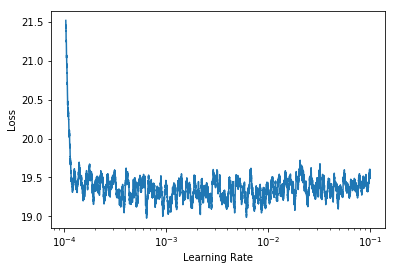

In [38]:
learner.plot_lrs(100)

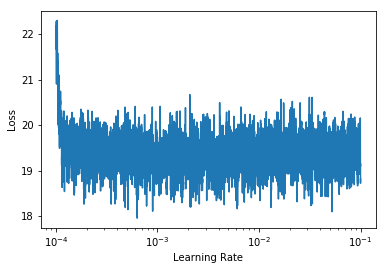

In [35]:

learner.plot_lrs(10)

In [39]:
del cfobj
torch.cuda.empty_cache()

In [40]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,dropout_e,hidden,dropouts)
cfobj=cfobj.to(device)

In [41]:
device

'cuda:0'

In [42]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=3e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [43]:
learner.run_epochs(dltrain,dlvalid,7)

Batch:12000 19.40125248559316  
Epoch:0 Learning rate 0.003 Weight Decay 1e-07 Train Loss:19.399859713110192                 Valid Loss:19.447790844279922 Train RMSE:4.402696846725378 Valid RMSE:4.408237157585492
Batch:12000 19.394977864583332  
Epoch:1 Learning rate 0.003 Weight Decay 1e-07 Train Loss:19.399827022412115                 Valid Loss:19.447522321010073 Train RMSE:4.40271021614717 Valid RMSE:4.408207224806532
Batch:12000 19.400893229166666  
Epoch:2 Learning rate 0.003 Weight Decay 1e-07 Train Loss:19.39986706812208                 Valid Loss:19.447775499516883 Train RMSE:4.402715384504119 Valid RMSE:4.408180577556689
Batch:12000 19.39429296875  
Epoch:3 Learning rate 0.003 Weight Decay 1e-07 Train Loss:19.399832704586416                 Valid Loss:19.447990318769605 Train RMSE:4.4026837166309605 Valid RMSE:4.408277429072537
Batch:12000 19.400279947916665  
Epoch:4 Learning rate 0.003 Weight Decay 1e-07 Train Loss:19.39983162227312                 Valid Loss:19.44717707604

In [44]:
torch.save(cfobj,f=f'{DATAPATH}/inter/cf_model')
torch.save(learner,f=f'{DATAPATH}/inter/cf_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/cf_optimizer')
torch.save(cfobj.state_dict(),f'{DATAPATH}/inter/cf_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/cf_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [45]:
optimizer=torch.optim.Adam(cfobj.parameters(),lr=3e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=5e-3,end_lr=5e-4)

In [46]:
learner.run_epochs(dltrain,dlvalid,15)

Batch:12000 19.411747395833334  
Epoch:0 Learning rate 0.003 Weight Decay 1e-07 Train Loss:19.399854892067996                 Valid Loss:19.447622058254915 Train RMSE:4.402726917540982 Valid RMSE:4.408127614655931
Batch:12000 19.388278645833335  
Epoch:1 Learning rate 0.0012247448713915891 Weight Decay 1e-07 Train Loss:19.399835680918493                 Valid Loss:19.44817444955765 Train RMSE:4.4026919621170055 Valid RMSE:4.4081924993128245
Batch:12000 19.391751302083332  
Epoch:2 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:19.399828645823078                 Valid Loss:19.447913598138623 Train RMSE:4.402688246151593 Valid RMSE:4.408188605909162
Batch:12000 19.391841145833332  
Epoch:3 Learning rate 0.003 Weight Decay 1e-07 Train Loss:19.399865985808784                 Valid Loss:19.448028679085095 Train RMSE:4.402709231572345 Valid RMSE:4.408147251109759
Batch:12000 19.399700520833335  
Epoch:4 Learning rate 0.0019168293127388174 Weight Decay 1e-07 Train Loss:19.399863550574374 

In [47]:
torch.save(cfobj,f=f'{DATAPATH}/inter/cf_model')
torch.save(learner,f=f'{DATAPATH}/inter/cf_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/cf_optimizer')
torch.save(cfobj.state_dict(),f'{DATAPATH}/inter/cf_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/cf_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
